# Credit Risk Underwriting Model


In this project, I build a logistic regression model to explain why customers default (“Default”). The purpose of this project is not just to build a robust model, but also to explain – in non-mathematical terms – the intuition behind it. 

### Part 1. Key Summary: 

#### 1. How I chose the variables that go into the model?

I used the recursive feature elimination Variable Selection technique and cross validation to select the variables. Basically, the process starts with the full model, and then delete 1 variable at once, and using cross validation to check the model performance (accuracy) when we deleting the variables. The best model is selected when the accurcy is maximum. 

#### 2. The relationship between each each variable and the model outcome?

There are 7 variables selected in the final logistic regression model. 'Duration','Amount','InstallmentRatePercentage','Telephone' and 'ForeignWorker' have positive coefficients. This means the increase of these five factor values can increase the probabilty of defaults. 'Age' and 'NumberExistingCredits' have negative coefficients. This means the increase of these two facotr values can decrease the probability of defaults. The relationship between each variable and the model outcome makes sense.

#### 3. Is the model accurate?

My model has good performance on non-defaulters. However, my model cannot predict defaulters very well. Since we care more about predicting defaulters correctly, this model is not satisfactory. One main reason for it is the available variables are not enough to account for the default behaviors. Some loan attributes, such as FICO score, Debt-to-Income, and some macroeconomical variables, such as Unemployment Rate, Housing Price Index and Disposable Income Index should be considered when building model.

### Part 2. Modeling and Analysis 

#### Step 0 - Import Libries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

#### Step 1 - Load & Explore Data 

(1) Load data

In [3]:
# Load Data
data = pd.read_excel('data/data.xlsx',index_col = None)
display(data.head(5))
display(data.tail(5))
print('Data has been sucessfully read in as a DataFrame')

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,Default
0,6,1169,4,4,67,2,1,0,1,0
1,48,5951,2,2,22,1,1,1,1,1
2,12,2096,2,3,49,1,2,1,1,0
3,42,7882,2,4,45,1,2,1,1,0
4,24,4870,3,4,53,2,2,1,1,1


,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,Default
995,12,1736,3,4,31,1,1,1,1,0
996,30,3857,4,4,40,1,1,0,1,0
997,12,804,4,4,38,1,1,1,1,0
998,45,1845,4,4,23,1,1,0,1,1
999,45,4576,3,4,27,1,1,1,1,0


Data has been sucessfully read in as a DataFrame


(2) Check dimension and index of total dataset

In [4]:
print('Shape of data: {}.'.format(data.shape))
print()
print('Row Index: {}.'.format(data.index))
print()
print('Columns Name: {}.'.format(data.columns))

Shape of data: (1000, 10).

Row Index: RangeIndex(start=0, stop=1000, step=1).

Columns Name: Index(['Duration', 'Amount', 'InstallmentRatePercentage', 'ResidenceDuration',
       'Age', 'NumberExistingCredits', 'NumberPeopleMaintenance', 'Telephone',
       'ForeignWorker', 'Default'],
      dtype='object').


(3) Check datatype of each column

In [5]:
display(data.dtypes)

Duration                     int64
Amount                       int64
InstallmentRatePercentage    int64
ResidenceDuration            int64
Age                          int64
NumberExistingCredits        int64
NumberPeopleMaintenance      int64
Telephone                    int64
ForeignWorker                int64
Default                      int64
dtype: object

***Summary:*** 

All variables have integer data type.

(4) Check whether there are any missing values in the total dataset

In [6]:
display(data.isnull().any())

Duration                     False
Amount                       False
InstallmentRatePercentage    False
ResidenceDuration            False
Age                          False
NumberExistingCredits        False
NumberPeopleMaintenance      False
Telephone                    False
ForeignWorker                False
Default                      False
dtype: bool

***Summary:***  There are no missing values in dataset.

###### So far, we have a big picture of the total dataset, the next we need to explore each vairables.

###### (1) Explore Continuous Variables

In [7]:
data[['Duration','Amount','Age']].describe()

,Duration,Amount,Age
count,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,35.546000
std,12.058814,2822.736876,11.375469
min,4.000000,250.000000,19.000000
25%,12.000000,1365.500000,27.000000
50%,18.000000,2319.500000,33.000000
75%,24.000000,3972.250000,42.000000
max,72.000000,18424.000000,75.000000


***Summary:***  The maximum, minimum and mean of these 3 continuous variables make sense.

The next, check the distribution of each continuous variable.

In [8]:
def histogram_plot(var_name):
    plt.hist(data[var_name])
    plt.xlabel(var_name)
    plt.ylabel('Counts')
    plt.title(var_name + ' Distribution')
    plt.show()

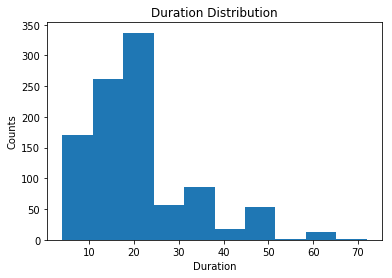

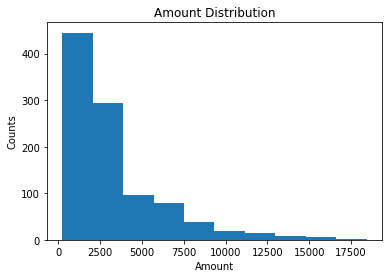

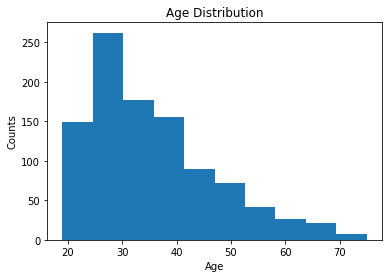

In [9]:
histogram_plot('Duration')
histogram_plot('Amount')
histogram_plot('Age')

***Summary*** The distribution of each continuous variable makes sense.

##### (2) Explore Categorial Variables

Checking the distribution of each categorial variables.

In [10]:
#Display Distribution 
data[['InstallmentRatePercentage','ResidenceDuration',
      'NumberExistingCredits','NumberPeopleMaintenance',
      'Telephone','ForeignWorker','Default']].apply(lambda col: col.value_counts().to_dict())

InstallmentRatePercentage    {4: 476, 2: 231, 3: 157, 1: 136}
ResidenceDuration            {4: 413, 2: 308, 3: 149, 1: 130}
NumberExistingCredits           {1: 633, 2: 333, 3: 28, 4: 6}
NumberPeopleMaintenance                      {1: 845, 2: 155}
Telephone                                    {1: 596, 0: 404}
ForeignWorker                                 {1: 963, 0: 37}
Default                                      {0: 700, 1: 300}
dtype: object

***Summary:***

(1) For 'InstallmentRatePercentage', 'ResidenceDuration', 'NumberExistingCredits' and 'NumberPeopleMaintenance', they are ordered categorial variables. The distribution makes sense.

(2) For 'Telephone' and 'ForeignWorker', they are Yes or No levels. The 1 and 0 coding is aligned with One-Hot coding. This coding can be directly used in logistic regresson modeling.

(3) 'Default' is the dependent variables. It is a little bit unbalanced, but it is acceptable.

#### Step 2 - Build Logistic Regression Model 

##### 1. Generate Training and Testing Dataset 

(1) Beforing doing modeling, checking the correlation between each independent varialbes. 

In [11]:
data[[col for col in data.columns if col != 'Default']].corr()

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker
Duration,1.000000,0.624984,0.074749,0.034067,-0.036136,-0.011284,-0.023834,-0.164718,0.138196
Amount,0.624984,1.000000,-0.271316,0.028926,0.032716,0.020795,0.017142,-0.276995,0.050050
InstallmentRatePercentage,0.074749,-0.271316,1.000000,0.049302,0.058266,0.021669,-0.071207,-0.014413,0.090024
ResidenceDuration,0.034067,0.028926,0.049302,1.000000,0.266419,0.089625,0.042643,-0.095359,0.054097
Age,-0.036136,0.032716,0.058266,0.266419,1.000000,0.149254,0.118201,-0.145259,0.006151
NumberExistingCredits,-0.011284,0.020795,0.021669,0.089625,0.149254,1.000000,0.109667,-0.065553,0.009717
NumberPeopleMaintenance,-0.023834,0.017142,-0.071207,0.042643,0.118201,0.109667,1.000000,0.014753,-0.077071
Telephone,-0.164718,-0.276995,-0.014413,-0.095359,-0.145259,-0.065553,0.014753,1.000000,-0.107401
ForeignWorker,0.138196,0.050050,0.090024,0.054097,0.006151,0.009717,-0.077071,-0.107401,1.000000


***Summary:***  There is no significant correlation, except for 'Duration' and 'Amount'.

(2) Since 'Amount' value is so huge compare to other variaibles, it is a good idea to do normailzation on each variable. 

In [12]:
data_normalized = data.apply(lambda col : (col-col.min())/(col.max()-col.min()))

(3) Generate training and testing dataset.

In [15]:
data_train, data_test = train_test_split(data_normalized, test_size = 0.2, random_state = 12345)

In [18]:
x_columns = [col for col in data.columns if col != 'Default']
data_train_x = data_train[x_columns]
data_train_y = data_train['Default']
data_test_x = data_test[x_columns]
data_test_y = data_test['Default']

##### 2. Build Benchmark Model

(1) Using all Variables. This is a benchmark model.

In [21]:
clf_bm = LogisticRegression(C= float(1e9),tol=0.0001, max_iter=1000,solver='lbfgs')
clf_bm.fit(data_train_x.values, data_train_y.values)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

Checking Accuracy of training and testing data:

In [22]:
print('Training data accuracy: {}'.format(clf_bm.score(data_train_x.values,data_train_y.values)))
print('Testing data accuracy: {}'.format(clf_bm.score(data_test_x.values,data_test_y.values)))

Training data accuracy: 0.71125
Testing data accuracy: 0.71


Calculate the AUC of the model.

In [23]:
data_train_y_pred_probability_bm = clf_bm.predict_proba(data_train_x.values)[:,1]
data_test_y_pred_probability_bm = clf_bm.predict_proba(data_test_x.values)[:,1]

In [24]:
auc_train = roc_auc_score(y_true=data_train_y, y_score=data_train_y_pred_probability_bm)
print('Trainging data AUC: {}'.format(auc_train))
auc_test = roc_auc_score(y_true=data_test_y, y_score=data_test_y_pred_probability_bm)
print('Testing data AUC: {}'.format(auc_test))

Trainging data AUC: 0.6683616565407532
Testing data AUC: 0.6497970573313039


***So far, the benchmark model looks Okay. We needs to check the significance of each variables.***

Since sklearn LogisticRegression model does not provide statistics of each variables, I use another package 'statsmodels' to perform the statistical analysis.

In [27]:
data_train_x_addingIntercept = sm.add_constant(data_train_x)
logit = sm.Logit(data_train_y, data_train_x_addingIntercept)
reg = logit.fit()
reg.summary()

Optimization terminated successfully.
         Current function value: 0.578041
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                  800
Model:                          Logit   Df Residuals:                      790
Method:                           MLE   Df Model:                            9
Date:                Sun, 12 Apr 2020   Pseudo R-squ.:                 0.06327
Time:                        12:39:48   Log-Likelihood:                -462.43
converged:                       True   LL-Null:                       -493.67
                                        LLR p-value:                 4.465e-10
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -3.2676      0.800     -4.085      0.000      -4.835      -1.700
Duration                      1.6740      0.587      2.854      0.004       0.524       2.824
Amount                        1.6050      0.705      2.278      0.023       0.224       2.986
InstallmentRatePercentage     0.7195      0.245      2.938      0.003       0.240       1.199
ResidenceDuration             0.1214      0.226      0.536      0.592      -0.322       0.565
Age                          -1.1276      0.442     -2.553      0.011      -1.993      -0.262
NumberExistingCredits        -0.6196      0.455     -1.362      0.173      -1.511       0.272
NumberPeopleMaintenance       0.1894      0.227      0.836      0.403      -0.255       0.634
Telephone                     0.4082      0.180      2.273      0.023       0.056       0.760
ForeignWorker                 1.3137      0.752      1.748      0.081      -0.160       2.787
=============================================================================================
"""

***Summary:*** 

After checking the significance of each variable, I find a few variables are not significant if considering alpha as 0.05. The benchmark model needs to be modified using variable selection.

##### (2) Build Final Model

Refine the benchmark model by performing recursive feature elimination Variable Selection and using cross validation to obtain the best model.

In [28]:
classifier = LogisticRegression(C= float(1e9),tol=0.0001, max_iter=1000, solver='lbfgs')
clf_final = RFECV(classifier, step=1, cv=5, scoring='accuracy')
clf_final = clf_final.fit(data_train_x, data_train_y)

Optimal number of features : 7


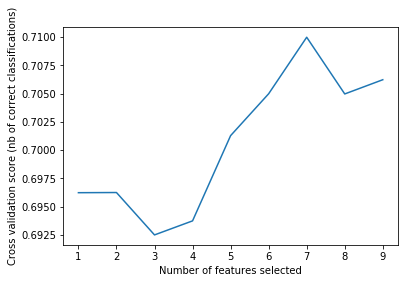

In [29]:
print("Optimal number of features : %d" % clf_final.n_features_)
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(clf_final.grid_scores_) + 1), clf_final.grid_scores_)
plt.show()

***Summary:***

There are 7 varaibles are selected.

In [30]:
data_train_x.columns[clf_final.support_]

Index(['Duration', 'Amount', 'InstallmentRatePercentage', 'Age',
       'NumberExistingCredits', 'Telephone', 'ForeignWorker'],
      dtype='object')

***Checking the significance of final model's variables***

In [31]:
data_train_x_select = data_train_x[data_train_x.columns[clf_final.support_]]
data_train_x_addingInte_select = sm.add_constant(data_train_x_select)
logit_select = sm.Logit(data_train_y, data_train_x_addingInte_select)
reg_select = logit_select.fit()
reg_select.summary()

Optimization terminated successfully.
         Current function value: 0.578640
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                  800
Model:                          Logit   Df Residuals:                      792
Method:                           MLE   Df Model:                            7
Date:                Sun, 12 Apr 2020   Pseudo R-squ.:                 0.06230
Time:                        12:43:41   Log-Likelihood:                -462.91
converged:                       True   LL-Null:                       -493.67
                                        LLR p-value:                 7.526e-11
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -3.1858      0.795     -4.008      0.000      -4.744      -1.628
Duration                      1.6907      0.585      2.888      0.004       0.543       2.838
Amount                        1.5841      0.704      2.250      0.024       0.204       2.964
InstallmentRatePercentage     0.7028      0.244      2.884      0.004       0.225       1.180
Age                          -1.0341      0.423     -2.443      0.015      -1.864      -0.204
NumberExistingCredits        -0.5837      0.453     -1.288      0.198      -1.472       0.305
Telephone                     0.4008      0.179      2.239      0.025       0.050       0.752
ForeignWorker                 1.3176      0.751      1.754      0.079      -0.155       2.790
=============================================================================================
"""

***There are still two variables that are not significant if considering alpha is 0.05.*** 

Checking Model Performance of final model on Training and Testing data.

In [32]:
print('Training data accuracy: {}'.format(clf_final.score(data_train_x.values,data_train_y.values)))
print('Testing data accuracy: {}'.format(clf_final.score(data_test_x.values,data_test_y.values)))

Training data accuracy: 0.7075
Testing data accuracy: 0.72


***Summary:*** 

By performing variable selection, some non-significant variables are removed. This prevents the overfitting, and it turns out the testing accuracy is improved.

In [33]:
data_train_y_pred_probability_final = clf_final.predict_proba(data_train_x.values)[:,1]
data_test_y_pred_probability_final = clf_final.predict_proba(data_test_x.values)[:,1]

auc_train_final = roc_auc_score(y_true=data_train_y, y_score=data_train_y_pred_probability_final)
print('Trainging data AUC: {}'.format(auc_train_final))
auc_test_final = roc_auc_score(y_true=data_test_y, y_score=data_test_y_pred_probability_final)
print('Testing data AUC: {}'.format(auc_test_final))

Trainging data AUC: 0.6675104927944586
Testing data AUC: 0.6470065956367326


***Summary:***

The AUC is comparable to the benchmark model.

***Note:***

The overall accuracy cannot gurantee that the model perform well for each class. Need to check the model performance on each class: Defaulters and non-Defaulters.

In [36]:
default_subsetting = (data_test_y == 1.0).values
non_default_subsetting = (data_test_y == 0.0).values

data_train_y_prediction_final = clf_final.predict(data_train_x.values)
data_test_y_prediction_final = clf_final.predict(data_test_x.values)

print('Test Dataset: True Positive Rate of Final Model: {}'.
      format((data_test_y_prediction_final[default_subsetting] == 
              data_test_y.values[default_subsetting]).mean()))

print('Test Dataset: True Negative Rate of Final Model: {}'.
      format((data_test_y_prediction_final[non_default_subsetting] == 
              data_test_y.values[non_default_subsetting]).mean()))

Test Dataset: True Positive Rate of Final Model: 0.09259259259259259
Test Dataset: True Negative Rate of Final Model: 0.952054794520548


***Conclusion***

As we can see, the model has good performance on non-defaulters. However, the model cannot predict defaulters well. Since we care more about predicting defaulters correctly, this model is not satisfactory. One main reason for this is the available variables can not well account for the default behaviors. Some loan attributes, such FICO score, Debt-to-Income, and some macroeconomical variables, such as Unemployment Rate, Housing Price Index and Disposable Income Index should be considered when building the model.  

***Further Checking Overfitting***

Two popular Regularization techniques -- Ridge and Lasso are quickly explored here. By performing cross-validation and these two techniques, the overfitting can be further reduced. 

(1) Lasso

In [40]:
data_train_x_select = data_train_x[data_train_x.columns[clf_final.support_]]
data_test_x_select = data_test_x[data_test_x.columns[clf_final.support_]]

In [41]:
clf_lasso = LogisticRegressionCV(Cs=10, fit_intercept=True, cv=5, penalty='l1', 
                                 solver='saga', tol=0.0001, max_iter=100, refit=True, random_state=12345)
clf_lasso.fit(data_train_x_select, data_train_y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l1',
           random_state=12345, refit=True, scoring=None, solver='saga',
           tol=0.0001, verbose=0)

In [42]:
clf_lasso.coef_ 

array([[ 1.69080972,  1.581892  ,  0.70224699, -1.03303185, -0.58255231,
         0.40034416,  1.31453674]])

In [43]:
print('Lasso Training data accuracy: {}'.format(clf_lasso.score(data_train_x_select.values,data_train_y.values)))
print('Lasso Testing data accuracy: {}'.format(clf_lasso.score(data_test_x_select.values,data_test_y.values)))

Lasso Training data accuracy: 0.7075
Lasso Testing data accuracy: 0.72


In [44]:
data_train_y_pred_probability_lasso = clf_lasso.predict_proba(data_train_x_select.values)[:,1]
data_test_y_pred_probability_lasso = clf_lasso.predict_proba(data_test_x_select.values)[:,1]

auc_train_lasso = roc_auc_score(y_true=data_train_y, y_score=data_train_y_pred_probability_lasso)
print('Lasso Trainging data AUC: {}'.format(auc_train_lasso))
auc_test_lasso = roc_auc_score(y_true=data_test_y, y_score=data_test_y_pred_probability_lasso)
print('Lasso Testing data AUC: {}'.format(auc_test_lasso))

Lasso Trainging data AUC: 0.6674444542279356
Lasso Testing data AUC: 0.6470065956367326


In [45]:
data_train_y_prediction_lasso = clf_lasso.predict(data_train_x_select.values)
data_test_y_prediction_lasso = clf_lasso.predict(data_test_x_select.values)

print('Test Dataset: True Positive Rate of Lasso Model: {}'.
      format((data_test_y_prediction_lasso[default_subsetting] == 
              data_test_y.values[default_subsetting]).mean()))

print('Test Dataset: True Negative Rate of Lasso Model: {}'.
      format((data_test_y_prediction_lasso[non_default_subsetting] == 
              data_test_y.values[non_default_subsetting]).mean()))

Test Dataset: True Positive Rate of Lasso Model: 0.09259259259259259
Test Dataset: True Negative Rate of Lasso Model: 0.952054794520548


(2) Ridge

In [46]:
clf_ridge = LogisticRegressionCV(Cs=10, fit_intercept=True, cv=5, penalty='l2', 
                                 solver='saga', tol=0.0001, max_iter=100, refit=True, random_state=12345)
clf_ridge.fit(data_train_x_select, data_train_y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=12345, refit=True, scoring=None, solver='saga',
           tol=0.0001, verbose=0)

In [47]:
clf_ridge.coef_ 

array([[ 1.69027605,  1.58135017,  0.70224636, -1.03287897, -0.58304813,
         0.40033466,  1.31286319]])

In [48]:
print('Ridge Training data accuracy: {}'.format(clf_ridge.score(data_train_x_select.values,data_train_y.values)))
print('Ridge Testing data accuracy: {}'.format(clf_ridge.score(data_test_x_select.values,data_test_y.values)))

Ridge Training data accuracy: 0.7075
Ridge Testing data accuracy: 0.72


In [49]:
data_train_y_pred_probability_ridge = clf_ridge.predict_proba(data_train_x_select.values)[:,1]
data_test_y_pred_probability_ridge = clf_ridge.predict_proba(data_test_x_select.values)[:,1]

auc_train_ridge = roc_auc_score(y_true=data_train_y, y_score=data_train_y_pred_probability_ridge)
print('Ridge Trainging data AUC: {}'.format(auc_train_ridge))
auc_test_ridge = roc_auc_score(y_true=data_test_y, y_score=data_test_y_pred_probability_ridge)
print('Ridge Testing data AUC: {}'.format(auc_test_ridge))

Ridge Trainging data AUC: 0.6674517918464383
Ridge Testing data AUC: 0.6470065956367326


In [50]:
data_train_y_prediction_ridge = clf_ridge.predict(data_train_x_select.values)
data_test_y_prediction_ridge = clf_ridge.predict(data_test_x_select.values)

print('Test Dataset: True Positive Rate of Ridge Model: {}'.
      format((data_test_y_prediction_ridge[default_subsetting] == 
              data_test_y.values[default_subsetting]).mean()))

print('Test Dataset: True Negative Rate of Ridge Model: {}'.
      format((data_test_y_prediction_ridge[non_default_subsetting] == 
              data_test_y.values[non_default_subsetting]).mean()))

Test Dataset: True Positive Rate of Ridge Model: 0.09259259259259259
Test Dataset: True Negative Rate of Ridge Model: 0.952054794520548


***Conclusion***

The Lasso and Ridge Regularization cannot further improve model's performance. So the Final Model I selected does not have overfitting problem. 